# Загрузка модели

{'bsize': 128, 'imsize': 64, 'nc': 3, 'nz': 100, 'ngf': 64, 'ndf': 64, 'nepochs': 10, 'lr': 0.0002, 'beta1': 0.5, 'save_epoch': 2}
Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


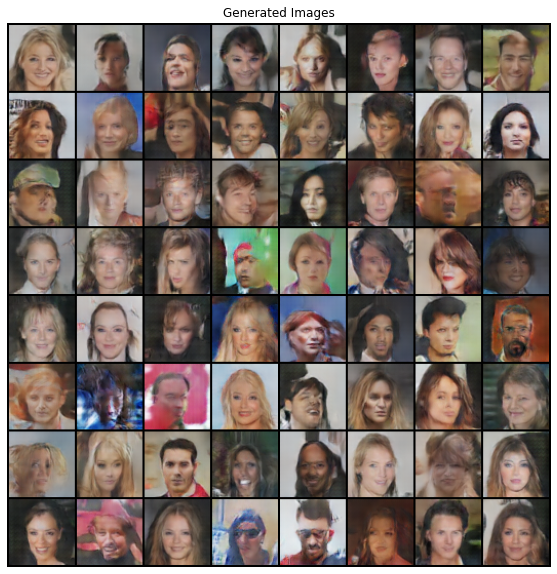

In [1]:
import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random

from dcgan import Generator

# Загрузка чекпоинта
state_dict = torch.load('./model_final.pth')


device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")
# Выделим параметры модели в отдельную переменную 
params = state_dict['params']

print(params)

# Генератор
netG = Generator(params).to(device)
# Загрузка весов генератора
netG.load_state_dict(state_dict['generator'])
print(netG)

# Получим латентный вектор из равномерного нормального распределения
noise = torch.randn(64, params['nz'], 1, 1, device=device)


with torch.no_grad():
	  # Получим сгенерированное изображение
    generated_img = netG(noise).detach().cpu()

    # Скейлинг от[-1,1] к [0,1]
    generated_img = (generated_img+ 1) / 2.0

# Выведим на экран сгенерированное изображение
plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0)))

Создаются 64 случайных точки в 100-мерном скрытом пространстве, используемые моделью генератора для генерации 64 изображений лиц, которые затем наносятся на сетку 8 × 8.

# Интерполяция между лицами

Мы можем создать путь интерполяции между двумя точками в скрытом пространстве и сгенерировать лица  вдоль этого пути.

Простейшая интерполяция, которую мы можем использовать, - это линейная или равномерная интерполяция между двумя точками в скрытом пространстве.  

Функция `get_interpolations()` возвращает линейно интерполированные вектора между двумя точками в скрытом пространстве, включая первую и последнюю точку.



In [2]:
def get_interpolations(noise1, noise2, num_interpolates):
    x = [((1.0 - (i/num_interpolates)) * noise1) + ((i/num_interpolates) * noise2) for i in range(num_interpolates + 1)]
    return torch.cat(x, dim = 0)

def random_noise(size):
    return torch.normal(0, 1, size, device = device)

with torch.no_grad():
    interpolations = []
    for _ in range(10):
        noise1 = torch.randn(1, params['nz'], 1, 1, device=device)
        noise2 = torch.randn(1, params['nz'], 1, 1, device=device)
        interpolations.append(get_interpolations(noise1, noise2, 9).to(device))
    
    interpolations = torch.cat(interpolations, dim = 0)
   
    generated_img = netG(interpolations).detach().cpu()
    

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


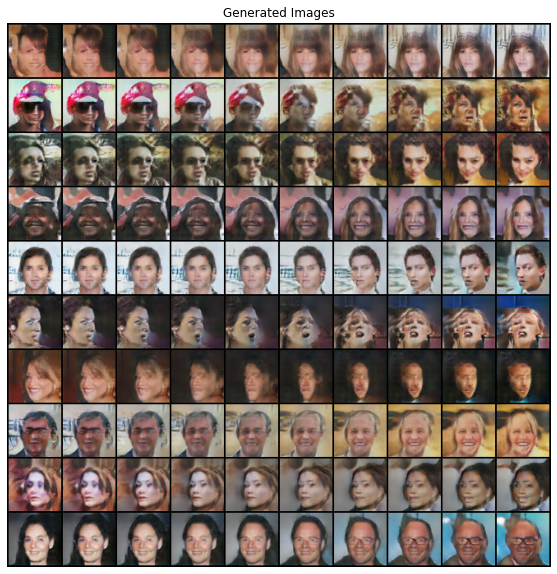

In [3]:
plt.figure(figsize = (10,10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True, nrow=10), (1,2,0)))

# Векторная арифметика

Наконец, мы можем исследовать скрытое пространство, выполняя векторную арифметику со сгенерированными лицами.

Мы должны сгенерировать несколько лиц и сохранить как лица, так и соответствующие им скрытые векторы. Затем мы можем просмотреть график сгенерированных лиц и выбрать лица с интересующими нас особенностями, отметить их индекс и получить их векторы скрытого пространства для дальнейшей работы.


In [4]:
from torchvision.utils import  make_grid

num_options = 100
generated_imgs = []
latent_vectors = []
padding = 2
for i in range(num_options):
    latent_vector = torch.randn(1, params['nz'], 1, 1, device=device)
    with torch.no_grad():
      generated_img = netG(latent_vector).detach().cpu()
    generated_imgs.append(generated_img) 
    latent_vectors.append(latent_vector.detach().cpu())
stacked_tensor_imgs = torch.stack(generated_imgs).view(100, 3, 64, 64)
final_tensor_img = make_grid(stacked_tensor_imgs, nrow=int(np.sqrt(num_options)), padding=padding, normalize=True)
display_img = np.moveaxis(final_tensor_img.numpy(), 0, 2)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [83]:
# Выделим индексы интересующих нас изображений
smiling_woman_ix = [1, 30, 33]
neutral_woman_ix = [12, 16, 7]
neutral_man_ix = [96, 43, 28]

In [84]:
happy_woman_latent_vectors = [latent_vectors[i].numpy() for i in smiling_woman_ix]
neutral_woman_latent_vectors = [latent_vectors[i].numpy() for i in neutral_woman_ix]
neutral_man_latent_vectors = [latent_vectors[i].numpy() for i in neutral_man_ix]

In [85]:
# Рассчитаем усредненный латентный вектор для каждой категории (счастливая женщина, нейтральная женщина, нейтральный мужчина)
happy_woman_avg_latent_vector = np.mean(np.array(happy_woman_latent_vectors), axis=0)
neutral_woman_avg_latent_vector = np.mean(np.array(neutral_woman_latent_vectors), axis=0)
neutral_man_avg_latent_vector = np.mean(np.array(neutral_man_latent_vectors), axis=0)

In [86]:
# Вычитая нейтральную женщину из счастливой, мы фиксируем «вектор улыбки».
# Добавляя этого вектора нейтральному мужчине, получаем скрытый вектор счастливого мужчины! 
happy_man_latent_vector = neutral_man_avg_latent_vector + (happy_woman_avg_latent_vector - neutral_woman_avg_latent_vector)

In [219]:
happy_man_latent_vector.shape

(1, 100, 1, 1)

In [87]:
with torch.no_grad():
      happy_women_imgs = np.hstack([netG(torch.Tensor(happy_woman_latent_vector).cuda()).view(3, 64, 64).detach().cpu() for happy_woman_latent_vector 
                                    in happy_woman_latent_vectors])
      neutral_women_imgs = np.hstack([netG(torch.Tensor(neutral_woman_latent_vector).cuda()).view(3, 64, 64).detach().cpu() for neutral_woman_latent_vector 
                                    in neutral_woman_latent_vectors])
      neutral_men_imgs = np.hstack([netG(torch.Tensor(neutral_man_latent_vector).cuda()).view(3, 64, 64).detach().cpu() for neutral_man_latent_vector 
                                    in neutral_man_latent_vectors]) 
      
      happy_woman_avg_img = netG(torch.Tensor(happy_woman_avg_latent_vector).cuda()).view(3, 64, 64).detach().cpu()
      neutral_woman_avg_img = netG(torch.Tensor(neutral_woman_avg_latent_vector).cuda()).view(3, 64, 64).detach().cpu()
      neutral_man_avg_img = netG(torch.Tensor(neutral_man_avg_latent_vector).cuda()).view(3, 64, 64).detach().cpu()
      happy_man_img = netG(torch.Tensor(happy_man_latent_vector).cuda()).view(3, 64, 64).detach().cpu()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Счастливая женщина


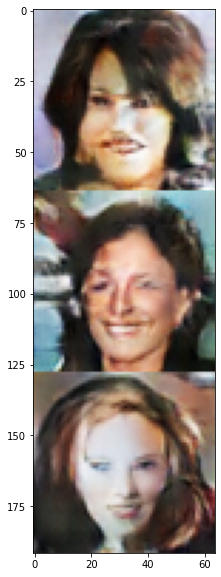

In [88]:
plt.figure(figsize = (10,10))
print('Счастливая женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(happy_women_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Нейтральная женщина


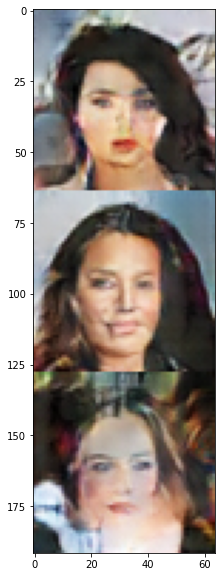

In [89]:
plt.figure(figsize = (10,10))
print('Нейтральная женщина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(neutral_women_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Нейтральный мужчина


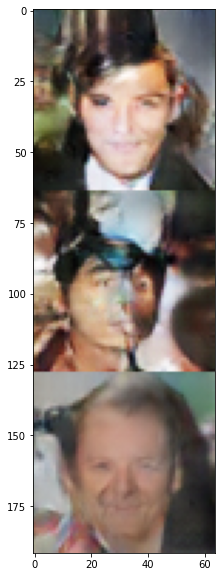

In [90]:
plt.figure(figsize = (10,10))
print('Нейтральный мужчина')
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(neutral_men_imgs), padding=2, normalize=True, nrow=10), (1,2,0)));

Резултьтат - счастливый мужчина


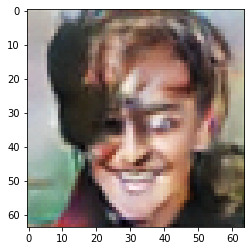

In [91]:
print('Резултьтат - счастливый мужчина')

plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(happy_man_img), padding=2, normalize=True, nrow=10), (1,2,0)));